In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import talib as ta
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [7]:
symbol='MSFT'
start='2018-01-01'
end='2019-12-31'
source='yahoo'
ndays_high=3
ndays_low=3
nATR=20
SL=1 #no of ATR to stoploss
TP=2
equity=10000


In [20]:
import yfinance as yf
#df=web.DataReader(symbol,source,start,end)
df=yf.download(symbol,start,end)
print(f'Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {symbol}')

[*********************100%***********************]  1 of 1 completed
Downloaded 502 rows and 6 columns of MSFT


In [21]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.004974,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.386620,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.111740,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.142174,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.228027,22113000


In [22]:
df1=df.copy()

In [23]:
df1.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.004974,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.386620,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.111740,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.142174,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.228027,22113000


In [24]:
df1['ATR']=ta.ATR(high=df1.High,low=df1.Low,close=df1.Close,timeperiod=nATR).shift(1)
df1.tail()

,Open,High,Low,Close,Adj Close,Volume,ATR
Date,,,,,,,
2019-12-23,158.119995,158.119995,157.270004,157.410004,155.044037,17718200,1.812954
2019-12-24,157.479996,157.710007,157.119995,157.380005,155.014450,8989200,1.764806
2019-12-26,157.559998,158.729996,157.399994,158.669998,156.285065,14520600,1.706066
2019-12-27,159.449997,159.550003,158.220001,158.960007,156.570709,18412800,1.688262
2019-12-30,158.990005,159.020004,156.729996,157.589996,155.221313,16348400,1.670349


In [25]:
df1['ndays_high']=df1['High'].rolling(ndays_high).max().shift(1)
df1['ndays_low']=df1['Low'].rolling(ndays_low).min().shift(1)
df1.tail(5)

,Open,High,Low,Close,Adj Close,Volume,ATR,ndays_high,ndays_low
Date,,,,,,,,,
2019-12-23,158.119995,158.119995,157.270004,157.410004,155.044037,17718200,1.812954,158.490005,153.750000
2019-12-24,157.479996,157.710007,157.119995,157.380005,155.014450,8989200,1.764806,158.490005,153.750000
2019-12-26,157.559998,158.729996,157.399994,158.669998,156.285065,14520600,1.706066,158.490005,156.289993
2019-12-27,159.449997,159.550003,158.220001,158.960007,156.570709,18412800,1.688262,158.729996,157.119995
2019-12-30,158.990005,159.020004,156.729996,157.589996,155.221313,16348400,1.670349,159.550003,157.119995


In [30]:
#run strategy
df1['signal']=''
df1['position']=0
df1['trade_price']=0
df1['trade_ret']=0
for i in range (0,len(df1)):
    #if there is an Open position carry the position and the entery price price
    if df1.iloc[i-1].position!=0:
        print(i,str(df1.index[i]),'carry position')
        df1.position.iloc[i]=df1.iloc[i-1].position
        df1.trade_price.iloc[i]=df1.iloc[i-1].trade_price
    #entery long
    if df1.iloc[i].High >df1.iloc[i].ndays_high and df1.iloc[i].position==0:
        print(i,str(df1.index[i]),'Entery long,price',df1.iloc[i].Close)
        df1.position.iloc[i]=1
        df1.trade_price.iloc[i]=df1.iloc[i].Open
        df1.signal.iloc[i]='Entery long'
    
    #check take profit and stoploss for long position
    elif df1.iloc[i].position==1:
        if df1.iloc[i].Close > df1.iloc[i].trade_price + df1.iloc[i].ATR *TP:
            print(i,str(df1.index[i]),'Take profit long,price',df1.iloc[i].Close)
            df1.position.iloc[i]=0
            df1.trade_ret.iloc[i]=df1.iloc[i].Open/df1.iloc[i].trade_price-1
            df1.trade_price.iloc[i]=df1.iloc[i].Open
            df1.signal.iloc[i]='TP long'
        elif df1.iloc[i].Close < df1.iloc[i].trade_price -df1.iloc[i].ATR *SL:
            print(i,str(df1.index[i]),'stop loss short,price',df1.iloc[i].Close)
            df1.position.iloc[i]=0
            df1.trade_ret.iloc[i]=df1.iloc[i].Open /df1.iloc[i].trade_price-1
            df1.trade_price.iloc[i]=df1.iloc[i].Open
            df1.signal.iloc[i]='SL long'
        
        #entery short
        elif df1.iloc[i].Low <df1.iloc[i].ndays_low and df1.iloc[i].position==0:
            print(i,str(df1.index[i]),'Entery short,price',df1.iloc[i].Close)
            df1.position.iloc[i]=-1
            df1.trade_price,iloc[i]=df1.iloc[i].Open
            df1.signal.iloc[i]='Entery short'
            
        #check take profit and stop loss for the short position
        elif df1.iloc[i].position ==-1:
            if df1.iloc[i].Close <df1.iloc[i].trade_price-df1.iloc[i].ATR *TP:
                print(i,STR(df1.index[i]),'Take profit short,price',df1.iloc[i].Close)
                df1.position.iloc[i]=0
                df1.trade_ret.iloc[i]=df1.iloc[i].trade_price/df1.iloc[i].Open-1
                df1.trade_price.iloc[i]=df1.iloc[i].Open
                df1.signal.iloc='TP short'
            elif df1.iloc[i].Close>df1.iloc[i].trade_price+df1.iloc[i].ATR*SL:
                print(i,str(df1.index[i]),'Stop loss short,price',df1.iloc[i].Close)
                df1.position.iloc[i]=0
                df1.trade_ret.iloc[i]=df1.iloc[i].trade_price/df1.iloc[i].Open-1
                df1.trade_price.iloc[i]=df1.iloc[i].Open
                df1.signal.iloc[i]='SL short'
            

3 2018-01-05 00:00:00 Entery long,price 88.19000244140625
4 2018-01-08 00:00:00 carry position
5 2018-01-09 00:00:00 carry position
6 2018-01-10 00:00:00 carry position
7 2018-01-11 00:00:00 carry position
8 2018-01-12 00:00:00 carry position
9 2018-01-16 00:00:00 carry position
10 2018-01-17 00:00:00 carry position
11 2018-01-18 00:00:00 carry position
12 2018-01-19 00:00:00 carry position
13 2018-01-22 00:00:00 carry position
14 2018-01-23 00:00:00 carry position
15 2018-01-24 00:00:00 carry position
16 2018-01-25 00:00:00 carry position
17 2018-01-26 00:00:00 carry position
18 2018-01-29 00:00:00 carry position
19 2018-01-30 00:00:00 carry position
20 2018-01-31 00:00:00 carry position
21 2018-02-01 00:00:00 carry position
21 2018-02-01 00:00:00 Take profit long,price 94.26000213623047
29 2018-02-13 00:00:00 Entery long,price 89.83000183105469
30 2018-02-14 00:00:00 carry position
31 2018-02-15 00:00:00 carry position
32 2018-02-16 00:00:00 carry position
33 2018-02-20 00:00:00 carr

249 2018-12-28 00:00:00 Entery long,price 100.38999938964844
250 2018-12-31 00:00:00 carry position
251 2019-01-02 00:00:00 carry position
252 2019-01-03 00:00:00 carry position
252 2019-01-03 00:00:00 stop loss short,price 97.4000015258789
253 2019-01-04 00:00:00 Entery long,price 101.93000030517578
254 2019-01-07 00:00:00 carry position
255 2019-01-08 00:00:00 carry position
256 2019-01-09 00:00:00 carry position
257 2019-01-10 00:00:00 carry position
258 2019-01-11 00:00:00 carry position
259 2019-01-14 00:00:00 carry position
260 2019-01-15 00:00:00 carry position
261 2019-01-16 00:00:00 carry position
262 2019-01-17 00:00:00 carry position
262 2019-01-17 00:00:00 Take profit long,price 106.12000274658203
263 2019-01-18 00:00:00 Entery long,price 107.70999908447266
264 2019-01-22 00:00:00 carry position
265 2019-01-23 00:00:00 carry position
266 2019-01-24 00:00:00 carry position
267 2019-01-25 00:00:00 carry position
268 2019-01-28 00:00:00 carry position
269 2019-01-29 00:00:00 c

In [33]:
df1.head(30)

,Open,High,Low,Close,Adj Close,Volume,ATR,ndays_high,ndays_low,signal,position,trade_price,trade_ret
Date,,,,,,,,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.004974,22483800,NaN,NaN,NaN,,0,0.000000,0.000000
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.386620,26061400,NaN,NaN,NaN,,0,0.000000,0.000000
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.111740,21912000,NaN,NaN,NaN,,0,0.000000,0.000000
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.142174,23407100,NaN,87.660004,85.500000,Entery long,1,87.660004,0.000000
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.228027,22113000,NaN,88.410004,85.970001,,1,87.660004,0.000000
2018-01-09,88.650002,88.730003,87.860001,88.220001,84.170799,19484300,NaN,88.580002,86.570000,,1,87.660004,0.000000
2018-01-10,87.860001,88.190002,87.410004,87.820000,83.789146,18652200,NaN,88.730003,87.430000,,1,87.660004,0.000000
2018-01-11,88.129997,88.129997,87.239998,88.080002,84.037224,17808900,NaN,88.730003,87.410004,,1,87.660004,0.000000
2018-01-12,88.669998,89.779999,88.449997,89.599998,85.487442,24271500,NaN,88.730003,87.239998,,1,87.660004,0.000000


<AxesSubplot:xlabel='Date'>

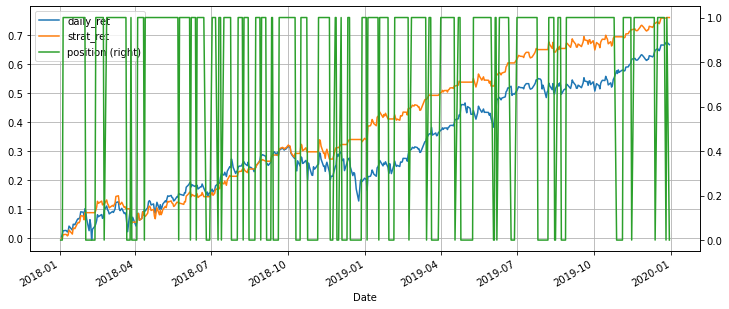

In [37]:
#compute daily return(buy and hold returns)
df1['daily_ret']=df1['Close'].pct_change()
#comput the strategy returns
df1['strat_ret']=df1['daily_ret']*df1['position']
#plot returns
df12=df1[['daily_ret','strat_ret']].cumsum()
df12['position']=df1['position']
df12[['daily_ret','strat_ret','position']].plot(secondary_y='position',grid=True,figsize=(12,5))

<AxesSubplot:xlabel='Date'>

Buy and hold returns:  1.83
Strategy returns:  2.08


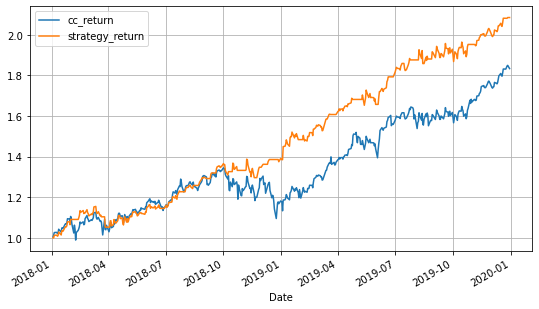

In [43]:
#compute daily return(buy and hold returns)
df1['cc_return']=(df1['Close'].pct_change())
#comput the strategy returns
df1['strategy_return']=df1['cc_return']*df1['position']
df1['cc_return']+=1
df1['strategy_return']+=1
df1[['cc_return', 'strategy_return']].cumprod().plot(grid=True, figsize=(9, 5))
#plot returns
#df12=df1[['daily_ret','strat_ret']].cumprod()
#df12['position']=df1['position']
#df12[['daily_ret','strat_ret','position']].plot(secondary_y='position',grid=True,figsize=(12,5))
print('Buy and hold returns: ', np.round(df1['cc_return'].cumprod()[-1], 2))
print('Strategy returns: ', np.round(df1['strategy_return'].cumprod()[-1], 2))